# Machine Learning (Summer 2021)

## Practice Session 9

### June 8st, 2021

Axel Schaffland & Ulf Krumnack

Institute of Cognitive Science,
University of Osnabrück

## Today's Session

* Diagonal of Correlation Matrix
* Logic Perceptron
* Deep Learning Resources
* Perceptron in Detail
* Tensorflow

## Is the diagonal of the correlation matrix always 1?

Wrong output: correlation should be 
 [[1.0, 0.0], [0.0, 0.0]] 

This is the right correlation matrix. But shouldn't be the diagonal always 1?

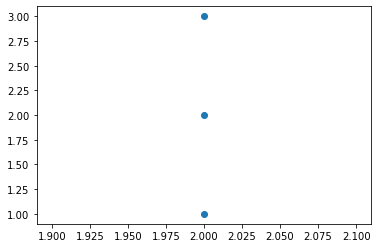

data:
[[1 2]
 [2 2]
 [3 2]]
centered data:
[[-1.  0.]
 [ 0.  0.]
 [ 1.  0.]]
covariance matrix:
[[2. 0.]
 [0. 0.]]


In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
def correlation(data):
    """
    Input is an array of the form number_data * dimensions
    An example is shown when this cell is executed
    """
    # YOUR CODE HERE
    print("data:\n{}".format(data))
    ### BEGIN SOLUTION
    centered = data - np.mean(data, axis=0)
    print("centered data:\n{}".format(centered))
    matrix = centered.T @ centered
    print("covariance matrix:\n{}".format(matrix))
    # Since the means are estimated from the data, we have to divide by |D|-1.
    # See https://en.wikipedia.org/wiki/Covariance_matrix#Estimation
    normalization_factor = 1 / (len(data)-1)
    stds = np.expand_dims(np.std(data, axis=0, ddof=1), axis=0)
    variance_matrix = np.transpose(stds) @ stds

    correlation_matrix = np.divide(normalization_factor * matrix, 
                                   variance_matrix, 
                                   out=np.zeros_like(matrix), 
                                   where=variance_matrix!=0)
    return correlation_matrix
    ### END SOLUTION


## DELETE COMMENTS TO SHOW THE DATA USED FOR ASSERTION
example_x = [2,2,2]
example_y = [1,2,3]
example_data = np.stack([[1,2,3], [2,2,2]], axis=1)
plt.scatter(example_x, example_y)
plt.show()

test_data1 = np.stack([[1,2,3], [2,2,2]], axis=1)
cor1 = correlation(test_data1)
real_cor1 = [[1.0, 0.0], [0.0, 0.0]]

assert np.allclose(cor1, real_cor1), "Wrong output: correlation should be \n {} \n for this data, is \n {}".format(real_cor1, cor1)

$$
\begin{bmatrix}
    cov(x,x) & cov(x,y) \\
    cov(y,x) & cov(y,y)
\end{bmatrix}$$

when
$$cov(y,y) = cov(y,y) = \frac{1}{n-1}\sum_{i=1}^{n}(y_i-\mu_y)(y_i-\mu_y) \leftarrow var(y)$$ 


if $y_1 = y_i$ for all $i={2\dots n} \rightarrow cov(y,y) = 0 \rightarrow cor(y,y) = 0$

## Resources on Artifical Neural Networks

* Next Semester in Osnabrueck:
    * [Vorlesung und Übung: Implementing ANNs with TensorFlow](https://studip.uni-osnabrueck.de/dispatch.php/course/details?sem_id=b16f30cfd047652abb0b01a5d617f84f)
    * [Seminar: Selected topics in deep learning](https://studip.uni-osnabrueck.de/dispatch.php/course/details?sem_id=6ed0a58e7f7d50d3456ff98b11225655)
* Book:
    * *Ian Goodfellow, Yoshua Bengio, et al.* 2016. Deep Learning
* Online:
    * [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/index.html)

# TensorFlow / Keras

## Installation

There exist two tensorflow packages that can be choosen for installation:
* `tensorflow`: basic CPU version
* `tensorflow-gpu`: support for dedicated CUDA graphic processing units (can speed up train by factor of 10-20)

### Installation of the CPU version

The CPU version can be installed with as follows (may take some time):

In [1]:
!conda install -c anaconda -y tensorflow 

Traceback (most recent call last):
  File "/usr/bin/conda", line 13, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda.cli'


### Installation of the GPU version

If you have a CUDA-enabled GPU, installing the GPU-version is an option.

On linux you may use `nvidia-smi` to check your GPU:

In [ ]:
!nvidia-smi

Installing the GPU version can be done as follows (may take even longer!):

In [ ]:
!conda install -c anaconda -y tensorflow-gpu

### Check your installation

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("TensorFlow can access the following GPUs:", tf.config.list_physical_devices('GPU'))
print("Eager execution:", tf.executing_eagerly())

TensorFlow version: 2.2.0
TensorFlow can access the following GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True


CPU and GPU performance:

In [2]:
import time

def measure(x, steps):
    # TensorFlow initializes a GPU the first time it's used, exclude from timing.
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    # tf.matmul can return before completing the matrix multiplication
    # (e.g., can return after enqueing the operation on a CUDA stream).
    # The x.numpy() call below will ensure that all enqueued operations
    # have completed (and will also copy the result to host memory,
    # so we're including a little more than just the matmul operation
    # time).
    _ = x.numpy()
    end = time.time()
    return end - start

In [3]:
shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# Run on GPU, if available:
if tf.config.experimental.list_physical_devices("GPU"):
    with tf.device("/gpu:0"):
        print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
    print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 0.7377219200134277 secs
GPU: 0.08017134666442871 secs


## Example: The iris dataset

Based on: [Custom training: walkthrough](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough)

### Prepare training data

Download the dataset:

In [4]:
import os

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /home/axel/.keras/datasets/iris_training.csv


Inspect the dataset:

In [5]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


Provide names for columns in the file:

In [6]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Prepare a tensorflow dataset:

In [7]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

`trainset` is a `tf.data.Dataset` of (features, label) pairs:
* where features is a dictionary: {'feature_name': value}

This dataset object is iterable. Inspect a batch of features:

In [8]:
features, labels = next(iter(train_dataset))
print(f"Feature keys: {features.keys()}")
print(f"Feature values for 'sepal_length': {features['sepal_length']}")
print(f"Feature values for 'sepal_width': {features['sepal_width']}")
print(f"Labels: {labels}")

Feature keys: odict_keys(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
Feature values for 'sepal_length': [6.7 5.9 6.4 5.8 4.5 5.1 5.4 4.6 5.  6.5 4.9 5.8 5.8 4.4 5.4 7.6 5.2 6.3
 5.8 4.8 7.2 5.1 5.5 5.5 6.5 4.9 6.8 6.9 6.2 6.4 5.  5.8]
Feature values for 'sepal_width': [3.1 3.2 2.8 4.  2.3 3.8 3.9 3.2 2.3 3.2 3.1 2.8 2.6 2.9 3.9 3.  3.5 3.3
 2.7 3.1 3.2 2.5 2.4 2.4 3.  3.1 3.  3.1 2.8 3.2 3.4 2.7]
Labels: [2 1 2 0 0 0 0 0 1 2 0 2 1 0 0 2 0 2 2 0 2 1 1 1 2 0 2 2 2 1 0 2]


Plot the data:

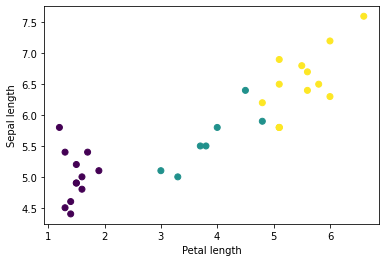

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

For further processing we require an array (not dict):

In [10]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

train_data_array = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_data_array))

print(features.shape)

(32, 4)


### Setting up a model

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

Apply the model to our data (just demo):

In [12]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.63007486,  1.2710476 , -0.662477  ],
       [-0.6237778 ,  1.255663  , -0.5182271 ],
       [-0.7121533 ,  1.2584938 , -0.6363567 ],
       [-0.6773635 ,  1.1054407 , -0.5411053 ],
       [-0.5309955 ,  1.3446649 , -0.29164752]], dtype=float32)>

Normalize the output vector (softmax):

In [13]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.11545316, 0.77277464, 0.1117722 ],
       [0.11545793, 0.7562311 , 0.128311  ],
       [0.10806067, 0.77536964, 0.11656971],
       [0.12357142, 0.7348185 , 0.14161009],
       [0.11369389, 0.74186707, 0.14443904]], dtype=float32)>

Determine the strongest output (using `argmax`):

In [14]:
tf.argmax(predictions[:5], axis=1)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 1, 1])>

Compare to target values (from training data):

In [15]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [1 1 2 1 0 0 0 2 0 1 1 1 2 1 1 0 1 1 2 1 1 0 0 2 2 2 0 0 1 0 0 0]


### Training

#### Defining a loss function

Use the `SparseCategoricalCrossentropy` loss function when there are more than two label classes.

In [16]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.3973275423049927


#### Obtaining gradients

Tensorflow can automatically compute gradients for a function:

In [17]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

Inspect the weight gradients for the current data:

In [18]:
grad(model, features, labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.3973275>,
 [<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
  array([[ 0.36917368,  0.        ,  0.        ,  0.        ,  0.56338364,
           0.        ,  0.        ,  0.20387006,  0.1847411 ,  0.21763974],
         [ 0.2907556 ,  0.        ,  0.        ,  0.        ,  0.3370393 ,
           0.        ,  0.        ,  0.11184624,  0.16225654,  0.10972802],
         [ 0.02137049,  0.        ,  0.        ,  0.        ,  0.2639362 ,
           0.        ,  0.        ,  0.11983199, -0.03782891,  0.15117864],
         [-0.02359112,  0.        ,  0.        ,  0.        ,  0.06900531,
           0.        ,  0.        ,  0.03584533, -0.03298202,  0.04866296]],
        dtype=float32)>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.08029528, 0.        , 0.        , 0.        , 0.10184926,
         0.        , 0.        , 0.03451674, 0.04535961, 0.03461172],
        dtype=float32)>,
  <tf.Tensor: shape=(10, 10), dtype=float32, numpy

### Providing an optimizer

Different optimizers can be used:
![Optimization algorithms visualized over time in 3D space](https://cs231n.github.io/assets/nn3/opt1.gif)
(Source: Stanford class CS231n, MIT License, Image credit: Alec Radford) 

An optimizer can be choosen from `tf.keras.optimizers`:

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [20]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

Step: 0, Initial Loss: 1.3973275423049927


### Initializing training

In [21]:
optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 1,         Loss: 1.3146450519561768


#### The training loop

In [22]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in train_data_array:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.379, Accuracy: 30.000%
Epoch 050: Loss: 0.415, Accuracy: 84.167%
Epoch 100: Loss: 0.279, Accuracy: 93.333%
Epoch 150: Loss: 0.211, Accuracy: 96.667%
Epoch 200: Loss: 0.164, Accuracy: 96.667%


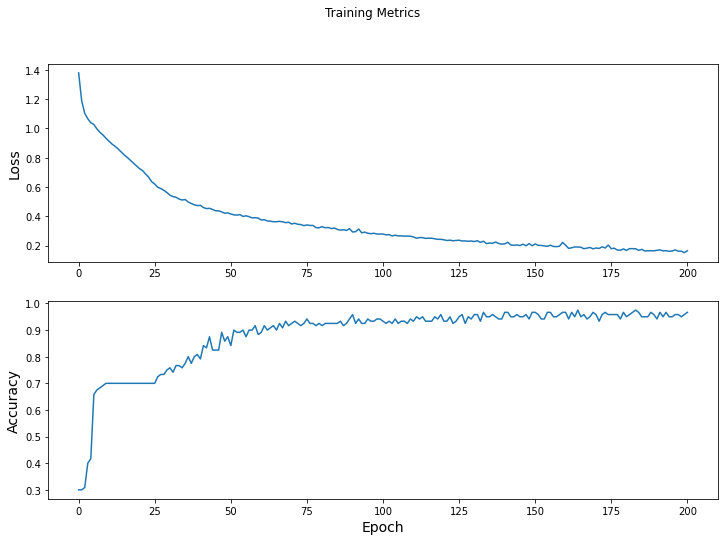

In [23]:
plt.subplots(2, sharex=True, figsize=(12, 8))
plt.suptitle('Training Metrics')
plt.subplot(2,1,1)
plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)

plt.subplot(2,1,2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.plot(train_accuracy_results)
plt.show()

### Evaluating the model

Download the test data:

In [24]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


Load the test dataset

In [25]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

Compute the test accuracy:

In [26]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


Inspect predictions on test data:

In [27]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

Show prediction for some examples:

In [28]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

In [29]:
# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.0%)
Example 1 prediction: Iris versicolor (91.6%)
Example 2 prediction: Iris virginica (65.5%)


## Example 2: MNIST

Load the MNIST character data:

In [30]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 1s 0us/step


Show example data:

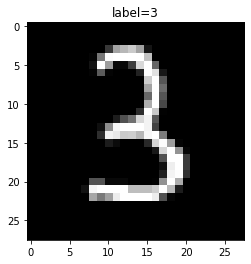

In [31]:
import random
n = random.randint(0, len(x_train))
plt.figure()
plt.gray(); plt.title(f"label={y_train[n]}"); plt.imshow(x_train[n])
plt.show()

Create a model:

In [32]:
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=(28, 28)),
tf.keras.layers.Dense(512, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model:

In [33]:
h = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2209 - accuracy: 0.9357
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959 - accuracy: 0.9703
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0692 - accuracy: 0.9778
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0519 - accuracy: 0.9837
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0432 - accuracy: 0.9862


Evaluate the model:

In [34]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 953us/step - loss: 0.0708 - accuracy: 0.9795


[0.07077594846487045, 0.9794999957084656]

## More information

You can have a look at the tensorflow tutorials:
https://www.tensorflow.org/tutorials/